# 5. Make linear predictions to the future (tas& prec)

In [14]:
## First, lets import all neeeded libraries

import os, sys
# import netCDF4
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import geopandas as gpd
import rioxarray
import xarray as xr
import glob

import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

In [2]:
from io import StringIO
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import math
from math import sqrt

In [3]:
pwd = os.getcwd()
print(pwd)

/Users/marie-christineckert/Nextcloud/TU/Lehre/AktuelleAnwendungen_SoSe24/7_GW_Model_Example


## 1. Examplary prediciton on one file

In [79]:
## which federal state are you working on?

bl = "BB"

In [4]:
data = pd.read_csv("./data/HYRAS_GWData_csv/BB_27381010_weeklyData_HYRAS_GWData.csv", skipinitialspace=True).drop(['Unnamed: 0'], axis=1)


data = data.set_index(pd.DatetimeIndex(data['Date']))
del data['Date']


data['Timestep'] = np.arange(len(data.index))

#df.head()
data.shape[0]

835

In [5]:
data.head()

,pr,tas,GWL,Timestep
Date,,,,
1990-01-01,1.0,-0.728571,NaN,0
1990-01-08,3.3,3.871429,NaN,1
1990-01-15,12.6,6.185714,NaN,2
1990-01-22,26.4,5.742858,NaN,3
1990-01-29,4.9,6.057143,NaN,4


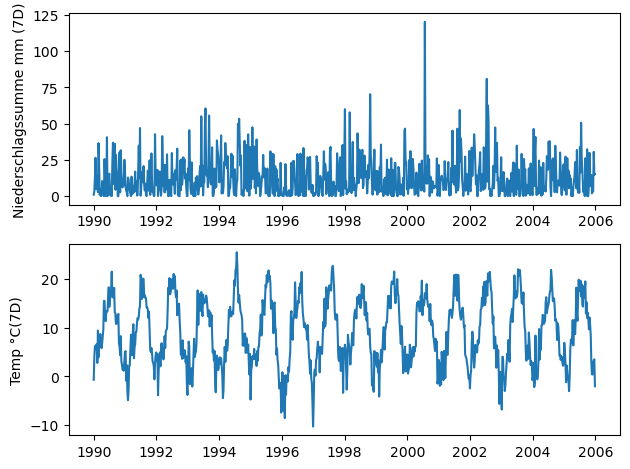

In [6]:

fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].plot(data.index, data.pr)
ax[0].set_ylabel("Niederschlagssumme mm (7D)")



ax[1].plot(data.index, data.tas)
ax[1].set_ylabel("Temp °C(7D)")
#plt.suptitle(well_id[number])


### add blockings to plot:



plt.tight_layout()
plt.show()

## 1. Perform Linear Regression

 We already know this step: setting up a new subdirectory to save our processed csv's in: 

In [77]:
## set current WD
os.chdir(pwd)

## specify wd
path = "data/"
new_dir = os.path.join(path, "Prediction_HYRAS_GWData_csv")
if not os.path.exists(new_dir):
    os.makedirs(new_dir)



new_dir

'data/Prediction_HYRAS_GWData_csv'

Next, we will built a prediciton dataframe. It has the same format as our original Dataframe, but pr and tas are initially nan.

In [7]:
## initialise empty df to store pred data in: 

pred_val = pd.DataFrame()
## find max year in ts to start pred from there
max_year = data.index.year.max()

## create daterange until desired date
pred_val['base_idx'] = pd.date_range(f'{max_year}', '2050-12-31', name='times', freq='7D')
pred_val["pr"] = np.nan
pred_val["tas"] = np.nan



pred_val['Timestep'] = list(range(data['Timestep'].max(),data['Timestep'].max()+len(pred_val.index)))
pred_val

,base_idx,pr,tas,Timestep
0,2005-01-01,NaN,NaN,834
1,2005-01-08,NaN,NaN,835
2,2005-01-15,NaN,NaN,836
3,2005-01-22,NaN,NaN,837
4,2005-01-29,NaN,NaN,838
...,...,...,...,...
2396,2050-12-03,NaN,NaN,3230
2397,2050-12-10,NaN,NaN,3231
2398,2050-12-17,NaN,NaN,3232
2399,2050-12-24,NaN,NaN,3233


We will now perform a linear regression on pr and tas respectively in order to make predicitons into the future. I chose 2050, but we might aso want to predict until 2100 as Wunsch et al. did. Recall the script on linear regression from the beginning of the semester.

> **Exercise**: Add feature scaling to the linear prediction!

In [8]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


In [9]:
from sklearn.linear_model import LinearRegression

# Training data
X = data.loc[:, ['Timestep']]  # features
y = data.loc[:, 'pr']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

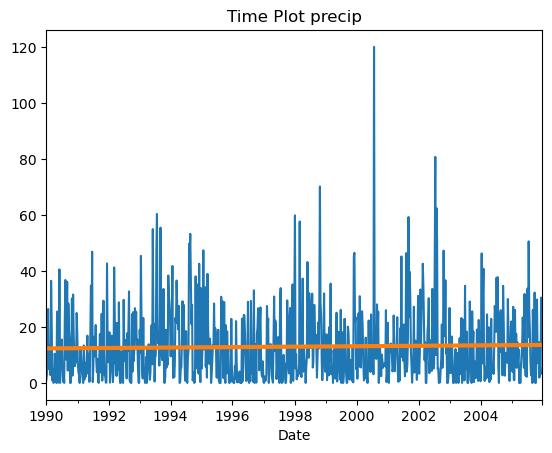

In [10]:

ax = y.plot()
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot precip');

In [11]:
y_pred_100 = model.predict(pred_val.loc[:, ['Timestep']])

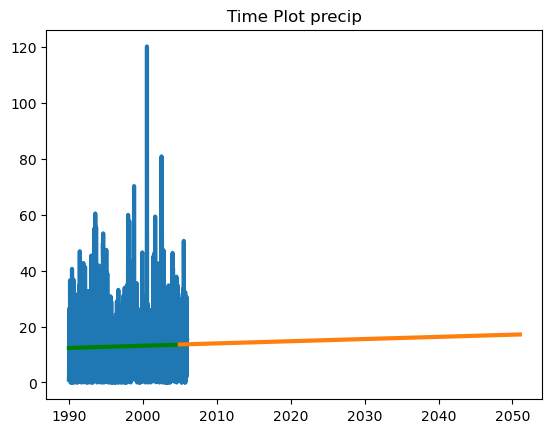

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(data.index, y, linewidth=3)
ax.plot(data.index, y_pred, linewidth=3, color = "green")



ax.plot(pred_val['base_idx'], y_pred_100, linewidth=3)
ax.set_title('Time Plot precip');

## 2. Performing predicitons on each file

We now saw how to predict a single file. We will now perform this code on all our stations and simply add the predicted rows the existing csv file. We will save them into a new directory. 

In [78]:
pwd = os.getcwd()
print(pwd)

/Users/marie-christineckert/Nextcloud/TU/Lehre/AktuelleAnwendungen_SoSe24/7_GW_Model_Example


In [17]:
# Load multiple CSV files
csv_files = glob.glob('data/HYRAS_GWData_csv/*.csv')  # Adjust the pattern as needed

In [56]:
pred_year = "2051"

In [93]:
# Prepare a list to hold the processed DataFrames
processed_samples = pd.DataFrame()

for file in csv_files:
    data = pd.read_csv(file, skipinitialspace=True).drop(['Unnamed: 0'], axis=1)
    data = data.set_index(pd.DatetimeIndex(data['Date']))
    del data['Date']
    data['Timestep'] = np.arange(len(data.index))

    ### initialise empty df to store pred data in: 
    pred_val = pd.DataFrame()
    
    ## find max year in ts to start pred from there
    max_year = data.index.year.max()

    ### create daterange until desired date
    pred_val['Date'] = pd.date_range(f'{max_year}', pred_year, name='times', freq='7D')
    pred_val["pr"] = np.nan
    pred_val["tas"] = np.nan
    pred_val['Timestep'] = list(range(data['Timestep'].max(),data['Timestep'].max()+len(pred_val.index)))

    ###############################
    ##### predict Precipitation
    X = data.loc[:, ['Timestep']]  # features
    y = data.loc[:, 'pr']  # target

    ###Train the model
    model_pr = LinearRegression()
    model_pr.fit(X, y)

    ### fit 
    pred_val["pr"]  = model_pr.predict(pred_val.loc[:, ['Timestep']])

    ###############################
    ####### predict Temperature
    X = data.loc[:, ['Timestep']]  # features
    y = data.loc[:, 'tas']  # target

    ### Train the model
    model_tas = LinearRegression()
    model_tas.fit(X, y)

    ### fit 
    pred_val["tas"]  = model_tas.predict(pred_val.loc[:, ['Timestep']])
   
    ## set datetimeindex of df for easy merging
    pred_val = pred_val.set_index(pd.DatetimeIndex(pred_val['Date']))
    del pred_val['Date']

    print(f"{file}.....PREDICTION successful")
    ##########
    ### Combine all processed samples into a single DataFrame
    processed_samples = pd.concat([data, pred_val], axis=0)
    
    ##############################
    ### save to csv

    ############ get name of stations
    ### Split the string by underscores
    parts = file[22:].split('_')
    # Join the first two parts to get the desired result
    well_id  = '_'.join(parts[1:2])
    #####naming convention
    file_ext_name = ".csv"
    file_end_name = "weeklyData_HYRAS_GWData_PREDICTIONS"
    file = f"{new_dir}/{bl}_{well_id}_{file_end_name}_{pred_year}{file_ext_name}"
    processed_samples.to_csv(file)
    print(f"{file}.....SAVING successful")


data/HYRAS_GWData_csv/BB_30400591_weeklyData_HYRAS_GWData.csv.....PREDICTION successful
data/Prediction_HYRAS_GWData_csv/BB_30400591_weeklyData_HYRAS_GWData_PREDICTIONS_2051.csv.....SAVING successful
data/HYRAS_GWData_csv/BB_40500136_weeklyData_HYRAS_GWData.csv.....PREDICTION successful
data/Prediction_HYRAS_GWData_csv/BB_40500136_weeklyData_HYRAS_GWData_PREDICTIONS_2051.csv.....SAVING successful
data/HYRAS_GWData_csv/BB_28390113_weeklyData_HYRAS_GWData.csv.....PREDICTION successful
data/Prediction_HYRAS_GWData_csv/BB_28390113_weeklyData_HYRAS_GWData_PREDICTIONS_2051.csv.....SAVING successful
data/HYRAS_GWData_csv/BB_29519030_weeklyData_HYRAS_GWData.csv.....PREDICTION successful
data/Prediction_HYRAS_GWData_csv/BB_29519030_weeklyData_HYRAS_GWData_PREDICTIONS_2051.csv.....SAVING successful
data/HYRAS_GWData_csv/BB_27381010_weeklyData_HYRAS_GWData.csv.....PREDICTION successful
data/Prediction_HYRAS_GWData_csv/BB_27381010_weeklyData_HYRAS_GWData_PREDICTIONS_2051.csv.....SAVING successful


In [72]:
file

'data/HYRAS_GWData_csv/BB_34522461_weeklyData_HYRAS_GWData.csv'

In [85]:
### naming convention







In [86]:


well_id

'34522461'

In [87]:
file

'data/HYRAS_GWData_csv/BB_34522461_weeklyData_HYRAS_GWData.csv'

In [92]:
#filepath = 



'data/Prediction_HYRAS_GWData_csv/BB_34522461_weeklyData_HYRAS_GWData_PREDICTIONS__2051.csv'